In [217]:
import numpy as np
import pandas as pd

import re
import string
import nltk
from nltk.corpus import stopwords

import xgboost as xgb
from xgboost import XGBRFClassifier
import seaborn as sns
import matplotlib.pyplot as pl






In [218]:
train=pd.read_csv('Sheet_1.csv',encoding='latin-1')
train.shape

(80, 8)

In [219]:
train.head()

,response_id,class,response_text,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,response_1,not_flagged,I try and avoid this sort of conflict,NaN,NaN,NaN,NaN,NaN
1,response_2,flagged,Had a friend open up to me about his mental ad...,NaN,NaN,NaN,NaN,NaN
2,response_3,flagged,I saved a girl from suicide once. She was goin...,NaN,NaN,NaN,NaN,NaN
3,response_4,not_flagged,i cant think of one really...i think i may hav...,NaN,NaN,NaN,NaN,NaN
4,response_5,not_flagged,Only really one friend who doesn't fit into th...,,NaN,NaN,NaN,NaN


In [220]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   response_id    80 non-null     object 
 1   class          80 non-null     object 
 2   response_text  80 non-null     object 
 3   Unnamed: 3     2 non-null      object 
 4   Unnamed: 4     0 non-null      float64
 5   Unnamed: 5     1 non-null      object 
 6   Unnamed: 6     0 non-null      float64
 7   Unnamed: 7     1 non-null      object 
dtypes: float64(2), object(6)
memory usage: 5.1+ KB


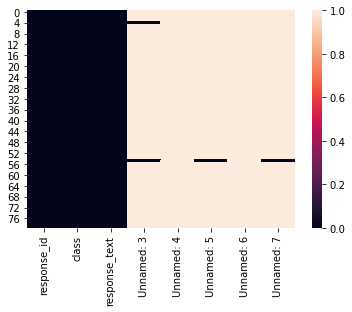

In [221]:
sns.heatmap(train.isnull())

In [222]:
train=train.drop(['response_id','Unnamed: 3','Unnamed: 4','Unnamed: 5','Unnamed: 6','Unnamed: 7'],axis=1)
train.head()

,class,response_text
0,not_flagged,I try and avoid this sort of conflict
1,flagged,Had a friend open up to me about his mental ad...
2,flagged,I saved a girl from suicide once. She was goin...
3,not_flagged,i cant think of one really...i think i may hav...
4,not_flagged,Only really one friend who doesn't fit into th...


In [223]:
test=pd.read_csv('Sheet_2.csv',encoding='latin-1')
test=test.drop(columns=['resume_id'],axis=1)
test.head()

,class,resume_text
0,not_flagged,\rCustomer Service Supervisor/Tier - Isabella ...
1,not_flagged,\rEngineer / Scientist - IBM Microelectronics ...
2,not_flagged,\rLTS Software Engineer Computational Lithogra...
3,not_flagged,TUTOR\rWilliston VT - Email me on Indeed: ind...
4,flagged,\rIndependent Consultant - Self-employed\rBurl...


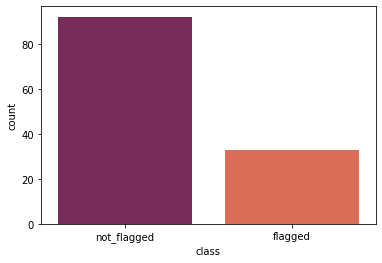

In [224]:
sns.countplot(test['class'],palette='rocket')

In [225]:
def clean_text(x):
    x=re.sub('\r','',x)
    x=re.sub('\n','',x)
    x=re.sub('\[.*>?\']','',x)
    x=re.sub(r'[\n\r\t\']','',x)
    x=re.sub(r'[^\w]', ' ', x)
    
    x=re.sub(r'[a-z0-9A-A]+@[a-z]+\.[a-z]+','',x)
#     x=re.sub(r'[^A-Za-z]','',x)
    x=' '.join(x.split())
    return x

In [226]:
train['Cleaned']=train['response_text'].apply(lambda x: clean_text(x))

In [227]:
train.head()

,class,response_text,Cleaned
0,not_flagged,I try and avoid this sort of conflict,I try and avoid this sort of conflict
1,flagged,Had a friend open up to me about his mental ad...,Had a friend open up to me about his mental ad...
2,flagged,I saved a girl from suicide once. She was goin...,I saved a girl from suicide once She was going...
3,not_flagged,i cant think of one really...i think i may hav...,i cant think of one really i think i may have ...
4,not_flagged,Only really one friend who doesn't fit into th...,Only really one friend who doesnt fit into the...


In [228]:
train['Cleaned'][57]

'My friend dealt with anxiety and this desire for everything in her life to be perfect she describes it as caring what happens to much but either way I simply talked to her and when she would try and change the subject I would have to drag her back in due the fact that she didnt want to talk about it but in reality she wouldnt get better unless i pulled her back into it and helped her through it But how i helped was by basically talking to her and giving her the advice she needed to hear not the one she wanted to such as oh youll be ok this will all blow over what i said was more along the lines of being so blunt that many may find it rude but for her and i it was essential to making any progress y friend dealt with anxiety and this desire for everything in her life to be perfect she describes it as caring what happens to much but either way I simply talked to her and when'

In [229]:
train['response_text'][3]

'i cant think of one really...i think i may have indirectly'

In [230]:
train['Cleaned'][:10]


0                I try and avoid this sort of conflict
1    Had a friend open up to me about his mental ad...
2    I saved a girl from suicide once She was going...
3    i cant think of one really i think i may have ...
4    Only really one friend who doesnt fit into the...
5    a couple of years ago my friends was going to ...
6    Roommate when he was going through death and l...
7    ive had a couple of friends you could say more...
8    Listened to someone talk about relationship tr...
9    I will always listen I comforted my sister whe...
Name: Cleaned, dtype: object

In [231]:
train['Prev_Len']=train['response_text'].apply(lambda x: len(x))
train['Cleaned_Len']=train['Cleaned'].apply(lambda x: len(x))

In [233]:
test['Cleaned']=test['resume_text'].apply(lambda x: clean_text(x))

In [237]:
train.head()

,class,response_text,Cleaned,Prev_Len,Cleaned_Len
0,not_flagged,I try and avoid this sort of conflict,I try and avoid this sort of conflict,37,37
1,flagged,Had a friend open up to me about his mental ad...,Had a friend open up to me about his mental ad...,122,122
2,flagged,I saved a girl from suicide once. She was goin...,I saved a girl from suicide once She was going...,130,127
3,not_flagged,i cant think of one really...i think i may hav...,i cant think of one really i think i may have ...,58,56
4,not_flagged,Only really one friend who doesn't fit into th...,Only really one friend who doesnt fit into the...,381,365


In [235]:
test['Prev_Len']=test['resume_text'].apply(lambda x: len(x))
test['Cleaned_Len']=test['Cleaned'].apply(lambda x: len(x))

In [236]:
test.head()

,class,resume_text,Cleaned,Prev_Len,Cleaned_Len
0,not_flagged,\rCustomer Service Supervisor/Tier - Isabella ...,Customer Service Supervisor Tier Isabella Cata...,5505,5229
1,not_flagged,\rEngineer / Scientist - IBM Microelectronics ...,Engineer Scientist IBM Microelectronics Divisi...,3129,2978
2,not_flagged,\rLTS Software Engineer Computational Lithogra...,LTS Software Engineer Computational Lithograph...,5779,5624
3,not_flagged,TUTOR\rWilliston VT - Email me on Indeed: ind...,TUTORWilliston VT Email me on Indeed indeed co...,4405,4280
4,flagged,\rIndependent Consultant - Self-employed\rBurl...,Independent Consultant Self employedBurlington...,4160,4011


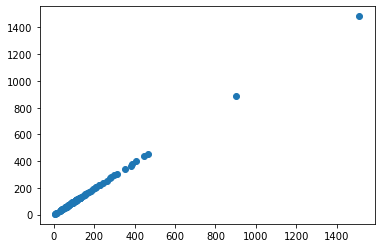

In [238]:
pl.scatter(train['Prev_Len'],train['Cleaned_Len'])

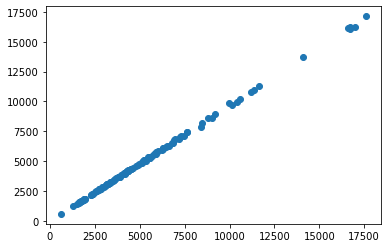

In [239]:
pl.scatter(test['Prev_Len'],test['Cleaned_Len'])